In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from os import environ
import os as os

In [2]:
home=environ['HOME']
folder1='GRIMech_CH4_models_RS3_15_trajectories'
folder2='Datasets'
folder3='interpolation-K-4'

name_1='State_space_cte_pressure_T1418_st-quarter_phi_'
name_2='Reaction_rates_cte_pressure_T1418_st-quarter_phi_'

end='.csv'

In [3]:
phis=[1.7,1.8]

In [4]:
def hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:]
    print(np.shape(cantera_species_fractions))
    
    cantera_species_fractions=cantera_species_fractions.loc[:,(cantera_species!=0).any(axis=0)]
    cantera_species_fractions=cantera_species_fractions.loc[:, (cantera_species != cantera_species.iloc[0]).any()]
    print(np.shape(cantera_species_fractions))
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    print(n_columns_mass_fraction)
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    print(np.shape(cantera_sources))
    n_columns_source=np.shape(cantera_sources)[1]
    print(n_columns_source)
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[:,1:]
    maximum_values=pd.concat([maximum_values.iloc[:,0:2],maximum_values.iloc[:,3:]],axis=1)
    #print(maximum_values)
    
    maximum_values=maximum_values.to_numpy()
    #print(np.shape(maximum_values))
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[0,j])
        #print(maximum_values[0,j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
coefficients=pd.read_csv('cluster3_coefficients.csv').to_numpy()
intercepts=pd.read_csv('cluster3_intercepts.csv').to_numpy()


coefficients=coefficients[:,1:]
intercepts=intercepts[:,1]
print(np.shape(coefficients))
print(np.shape(intercepts))

(31, 596)
(31,)


In [11]:
equivalence_ratios=1 #indices I'm interested in
print(phis[equivalence_ratios])

1.8


(120000, 49)
(120000, 30)
30
(120000, 30)
30
1.8


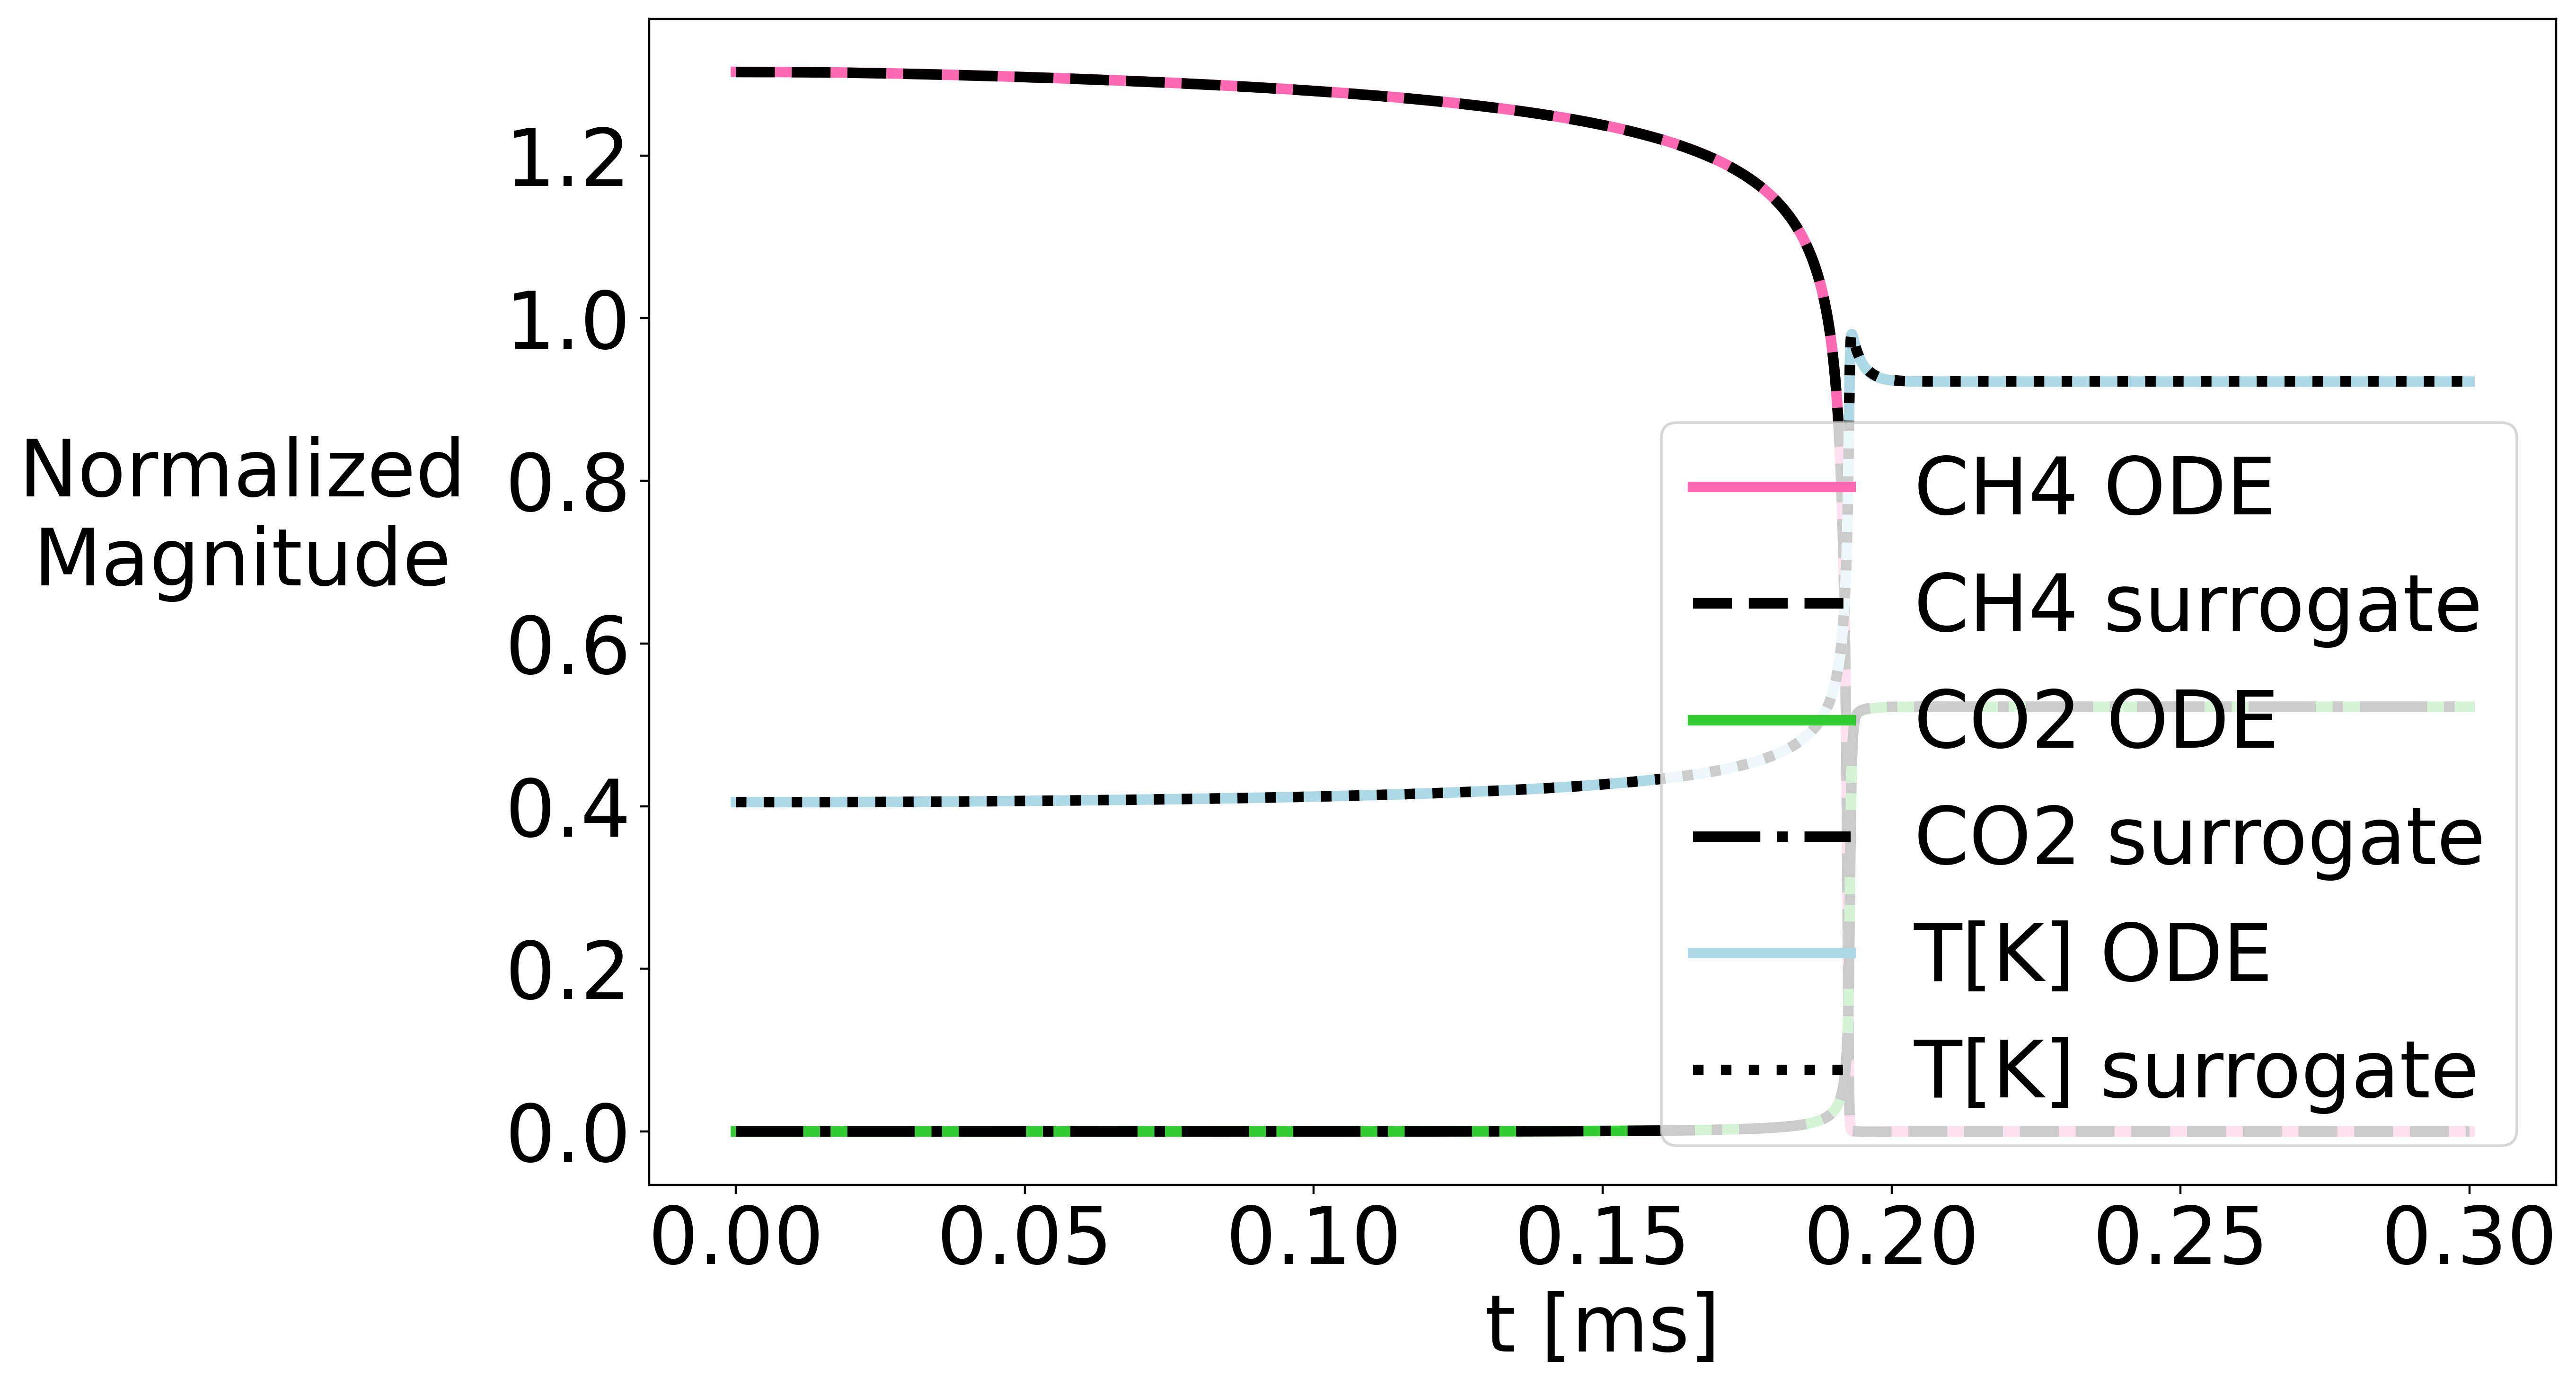

In [12]:
colors=['hotpink', 'limegreen', 'lightblue', 'orange']
linestyle=['dashed', 'dashdot', 'dotted']

cantera_species=pd.read_csv(join(home,folder1,folder2,folder3,name_1+str(equivalence_ratios)+end))
cantera_species=pd.DataFrame(cantera_species)
    
cantera_sources=pd.read_csv(join(home,folder1,folder2,folder3,name_2+str(equivalence_ratios)+end))
cantera_sources=pd.DataFrame(cantera_sources)
    
maximum_values=pd.read_csv(join(home,folder1,folder2,'maximum_values_T1418.csv'))
maximum_values=pd.DataFrame(maximum_values)
    
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values)
    
n_samples=np.shape(dataset)[0]
attach=np.ones((n_samples,1))*phis[equivalence_ratios]
print(phis[equivalence_ratios])
attach=pd.DataFrame(attach, columns=['Phi'])
dataset=pd.concat([dataset, attach],axis=1)
    
latent_features=['OH', 'CH3OH','CH3', 'CH3O', 'H', 'CH2OH', 'C2H5', 'CH4', 'O', 'HO2', 'CO', 'O2','CO2','H2','C','HCO', 'HCCO', 'Phi']
    
prediction_features=np.zeros((np.shape(dataset)[0],len(latent_features)))

for m in range(len(latent_features)):
    label=latent_features[m]
    prediction_features[:,m]=dataset.loc[:,label]
            
prediction_features=pd.DataFrame(prediction_features, columns=latent_features)
        
predictions_f=prediction_features
    
basis=prediction_features.iloc[:,:-1].to_numpy()
basis_squared=basis**2
for k in range(len(latent_features)-1): 
    #print(i)
    for j in range(np.shape(basis)[1]):
        #print(j)
        new_features=np.multiply(basis[:,j],prediction_features.iloc[:,k].to_numpy())
        new_features_squared=np.multiply(basis_squared[:,j],prediction_features.iloc[:,k].to_numpy())
        new_features=pd.DataFrame(new_features)
        new_features_squared=pd.DataFrame(new_features_squared)
        predictions_f=pd.concat([predictions_f,new_features,new_features_squared],axis=1)
    
output_start=3+n_columns_mass_fraction+n_columns_source
output_end=output_start+n_columns_mass_fraction+1
Outputs=dataset.iloc[:,output_start:output_end]
    
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]*1e3
    
out_columns=columns[1:2+n_columns_mass_fraction]
    
species_of_interest=['CH4', 'CO2', 'T[K]']

from sklearn.metrics import mean_squared_error
MSE_values1=np.zeros(len(species_of_interest))

    
indexes_species=np.zeros(len(species_of_interest))
    
for l in range(len(species_of_interest)):
    indexes_species[l]=columns.index(species_of_interest[l])-1
    
for j in range(len(indexes_species)):        
    k=int(indexes_species[j])
    prediction=np.matmul(predictions_f,np.transpose(coefficients[k,:]))+intercepts[k]
    label=out_columns[k]
            
    transformation_index=maximum_values.columns.get_loc(label)
    original=Outputs.iloc[:,k]#*maximum_values.iloc[0,transformation_index]
    reconstruction=prediction#*maximum_values.iloc[0,transformation_index]
    
    MSE_values1[j]=mean_squared_error(original,reconstruction)
    #relative_errors1[j]=np.sum((original-reconstruction)/(original+1e-3))/len(original)
            
    plt.figure(1,figsize=(13, 8), dpi=400)
    plt.plot(time_plot,original, label=species_of_interest[j]+' ODE', linewidth=4, color=colors[j])
    plt.plot(time_plot,reconstruction, label=species_of_interest[j]+' surrogate', linewidth=4, color='k',linestyle=linestyle[j])
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylabel('Normalized\nMagnitude', fontsize=30, rotation='horizontal',labelpad=100)
    plt.xlabel('t [ms]', fontsize=30)
    plt.legend(loc='lower right', fontsize=30)
    plt.savefig('Other_species-clusterb_test_'+str(equivalence_ratios)+'.jpg',dpi=400,bbox_inches='tight')


In [13]:
MSE_values1

array([1.75081769e-08, 8.23027584e-09, 2.40979356e-08])

(120000, 49)
(120000, 30)
30
(120000, 30)
30
1.8


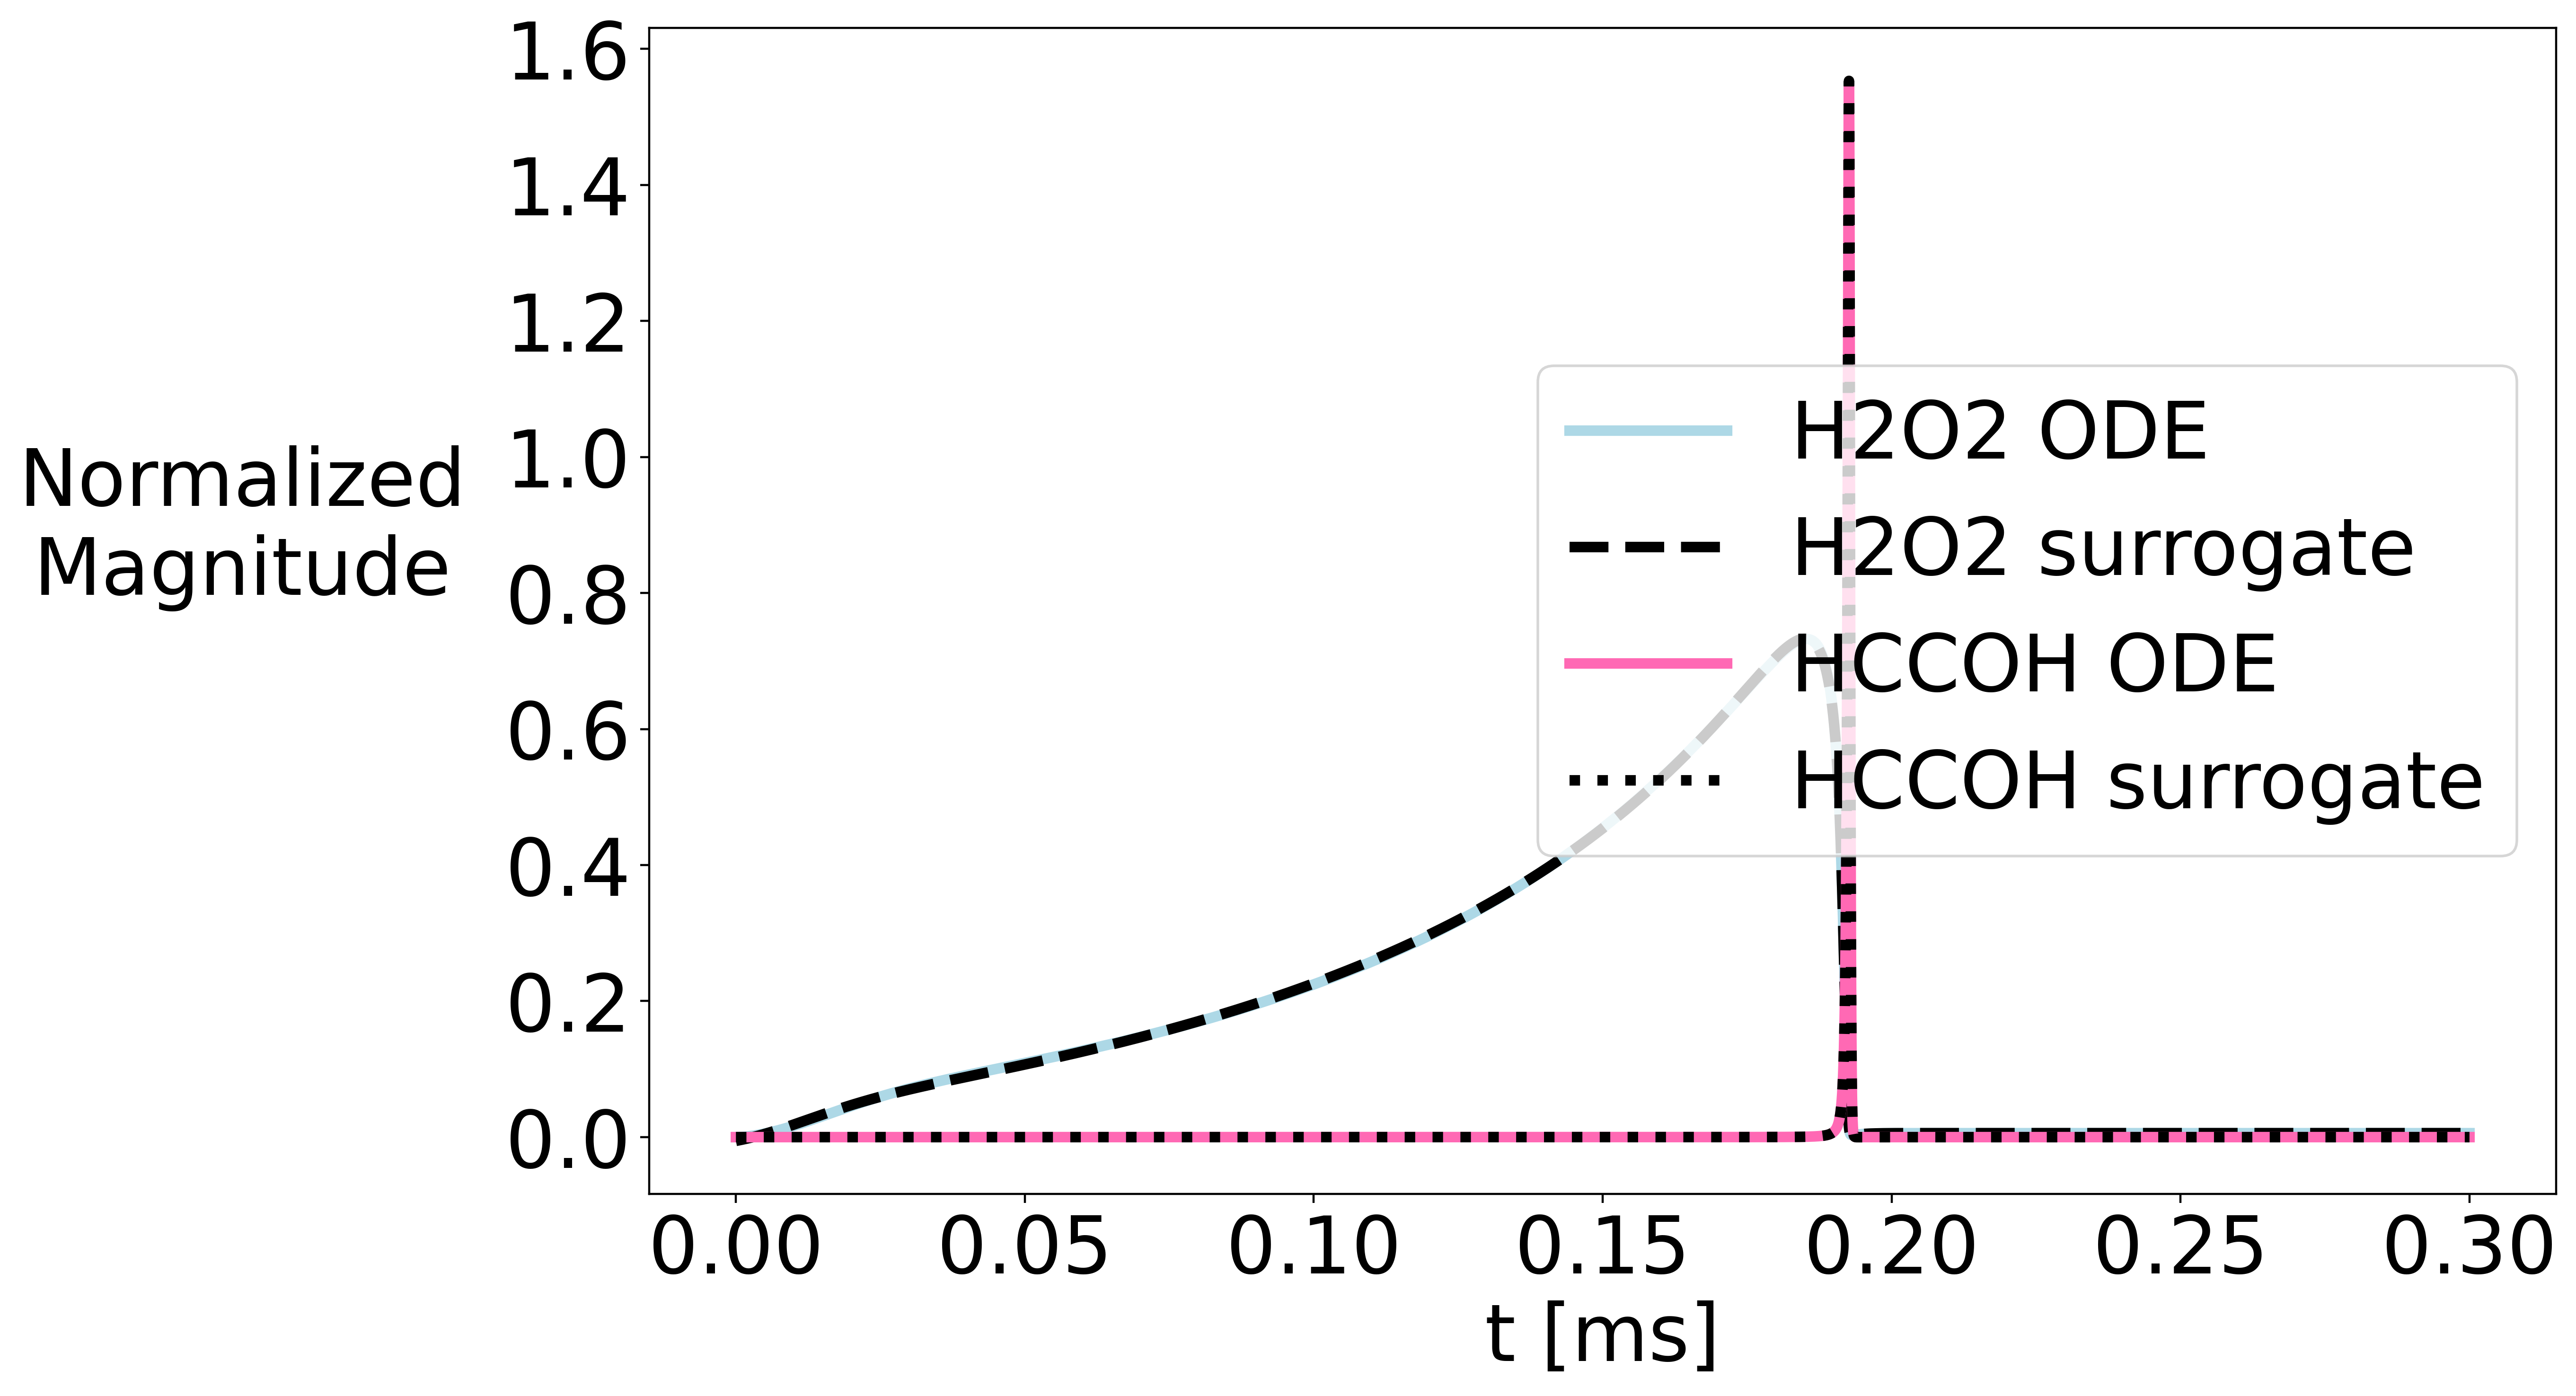

In [14]:
colors=['lightblue', 'hotpink', 'mediumseagreen', 'orange']

cantera_species=pd.read_csv(join(home,folder1,folder2,folder3,name_1+str(equivalence_ratios)+end))
cantera_species=pd.DataFrame(cantera_species)
    
cantera_sources=pd.read_csv(join(home,folder1,folder2,folder3,name_2+str(equivalence_ratios)+end))
cantera_sources=pd.DataFrame(cantera_sources)
    
maximum_values=pd.read_csv(join(home,folder1,folder2,'maximum_values_T1418.csv'))
maximum_values=pd.DataFrame(maximum_values)
    
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values)
    
n_samples=np.shape(dataset)[0]
attach=np.ones((n_samples,1))*phis[equivalence_ratios]
print(phis[equivalence_ratios])
attach=pd.DataFrame(attach, columns=['Phi'])
dataset=pd.concat([dataset, attach],axis=1)
    
latent_features=['OH', 'CH3OH','CH3', 'CH3O', 'H', 'CH2OH', 'C2H5', 'CH4', 'O', 'HO2', 'CO', 'O2','CO2','H2','C','HCO', 'HCCO', 'Phi']
    
prediction_features=np.zeros((np.shape(dataset)[0],len(latent_features)))

for m in range(len(latent_features)):
    label=latent_features[m]
    prediction_features[:,m]=dataset.loc[:,label]
            
prediction_features=pd.DataFrame(prediction_features, columns=latent_features)
        
predictions_f=prediction_features
    
basis=prediction_features.iloc[:,:-1].to_numpy()
basis_squared=basis**2
for k in range(len(latent_features)-1): 
    #print(i)
    for j in range(np.shape(basis)[1]):
        #print(j)
        new_features=np.multiply(basis[:,j],prediction_features.iloc[:,k].to_numpy())
        new_features_squared=np.multiply(basis_squared[:,j],prediction_features.iloc[:,k].to_numpy())
        new_features=pd.DataFrame(new_features)
        new_features_squared=pd.DataFrame(new_features_squared)
        predictions_f=pd.concat([predictions_f,new_features,new_features_squared],axis=1)
    
output_start=3+n_columns_mass_fraction+n_columns_source
output_end=output_start+n_columns_mass_fraction+1
Outputs=dataset.iloc[:,output_start:output_end]
    
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]*1e3
    
out_columns=columns[1:2+n_columns_mass_fraction]
    
species_of_interest=['H2O2','HCCOH',]
linestyle=['dashed','dotted', 'dashdot']

MSE_values2=np.zeros(len(species_of_interest))
#relative_errors2=np.zeros(len(species_of_interest))
    
indexes_species=np.zeros(len(species_of_interest))
    
for l in range(len(species_of_interest)):
    indexes_species[l]=columns.index(species_of_interest[l])-1
    
for j in range(len(indexes_species)):        
    k=int(indexes_species[j])
    prediction=np.matmul(predictions_f,np.transpose(coefficients[k,:]))+intercepts[k]
    label=out_columns[k]
            
    transformation_index=maximum_values.columns.get_loc(label)
    original=Outputs.iloc[:,k]#*maximum_values.iloc[0,transformation_index]
    reconstruction=prediction#*maximum_values.iloc[0,transformation_index]
    
    MSE_values2[j]=mean_squared_error(original,reconstruction)
    #relative_errors2[k]=np.sum((original-reconstruction)/(original+1e-5))/len(original)
            
    plt.figure(1,figsize=(13, 8), dpi=400)
    plt.plot(time_plot,original, label=species_of_interest[j]+' ODE', linewidth=4, color=colors[j] )
    plt.plot(time_plot,reconstruction, label=species_of_interest[j]+' surrogate', linewidth=4, color='k',linestyle=linestyle[j])
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylabel('Normalized\nMagnitude', fontsize=30,rotation='horizontal',labelpad=100)
    plt.xlabel('t [ms]', fontsize=30)
    plt.legend(loc='center right', fontsize=30)
    plt.savefig('Chemical_carriers-clusterb_test_'+str(equivalence_ratios)+'.jpg',dpi=400,bbox_inches='tight')


In [15]:
MSE_values2

array([1.44738104e-06, 1.56238313e-08])